# Predicting Deutsche Bahn Train Delays  
## A Reproducible Baseline for Supervised Regression

**Objective:** Build a supervised regression model to predict train arrival delays (in minutes) for Deutsche Bahn trains using statistical learning methods.

**Target Variable:** `arrival_delay_m` - continuous variable representing delay in minutes

---

## 1. Environment Setup and Imports

### Google Colab Setup

In [1]:
# Check if running in Google Colab
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    print("Running in Google Colab")

    # Install required packages
    %pip install pandas numpy matplotlib seaborn scikit-learn scipy kagglehub mlxtend psutil -q

    # Mount Google Drive (optional - for saving results)
    from google.colab import drive
    drive.mount('/content/drive')

    # Set memory-efficient pandas options
    import pandas as pd
    pd.options.mode.chained_assignment = None
    pd.options.display.max_columns = 50

else:
    print("Running locally")

Running in Google Colab
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 18.0 MB/s eta 0:00:00
Mounted at /content/drive


### Local Setup (Anaconda/Miniconda)

For local installation, follow these steps in your terminal:

```bash
# 1. Install Anaconda or Miniconda
# Download from: https://www.anaconda.com/download or https://docs.conda.io/en/latest/miniconda.html

# 2. Create a new conda environment
conda create -n ml-db-delays python=3.9 -y

# 3. Activate the environment
conda activate ml-db-delays

# 4. Install required packages
conda install -c conda-forge pandas numpy matplotlib seaborn scikit-learn scipy jupyter notebook ipykernel -y

# 5. Install additional packages via pip
pip install kagglehub

# 6. Add kernel to Jupyter
python -m ipykernel install --user --name ml-db-delays --display-name "ML DB Delays"

# 7. Launch Jupyter Notebook
jupyter notebook

# 8. Select the "ML DB Delays" kernel when creating/opening the notebook
```

### Mathematical Foundation (ISLR Chapter 2.1)

We model the relationship between predictors and response as:

$$Y = f(X) + \epsilon$$

where:
- $Y$ is the response variable (arrival delay in minutes)
- $X = (X_1, X_2, ..., X_p)$ represents our $p$ predictors
- $f$ is the unknown systematic function we aim to estimate
- $\epsilon$ is the irreducible error with $E(\epsilon) = 0$

Our goal is to estimate $\hat{f}$ such that $\hat{Y} = \hat{f}(X)$ minimizes the expected prediction error:

$$E[(Y - \hat{Y})^2] = E[(f(X) + \epsilon - \hat{f}(X))^2]$$

### Import Required Libraries

In [2]:
# Standard library imports
import os
import sys
import gc
import warnings
from datetime import datetime
import psutil

# Data manipulation
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine Learning
from sklearn.model_selection import (
    train_test_split, cross_val_score, GridSearchCV,
    KFold, learning_curve
)
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error
)
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# Statistical analysis
from scipy import stats

# Kaggle data loading
import kagglehub

# Configuration
warnings.filterwarnings('ignore')
np.random.seed(42)

# Memory-efficient pandas settings
pd.options.mode.chained_assignment = None
pd.options.display.max_columns = 50
pd.options.display.max_rows = 100

# Plotting configuration
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 12
plt.rcParams['figure.dpi'] = 100  # Reduce DPI for memory efficiency

# Memory monitoring function
def check_memory():
    """Monitor memory usage"""
    if 'psutil' in sys.modules:
        process = psutil.Process(os.getpid())
        mem_info = process.memory_info()
        return f"Memory Usage: {mem_info.rss / 1024 / 1024 / 1024:.2f} GB"
    else:
        return "psutil not available - install with: pip install psutil"

print("All packages imported successfully!")
print(check_memory())

All packages imported successfully!
Memory Usage: 0.26 GB


---

## 2. Data Loading and Initial Inspection

### The Supervised Learning Workflow (Lecture Slides)

Following the supervised learning experiment steps:
1. **Training data** → **Preprocessing** → **Feature extraction** → **Feature selection** → **Training**
2. **Test data** → **Preprocessing** → **Selected feature extraction** → **Classifier** → **Classification result**


In [3]:
# Download dataset
print("Downloading Deutsche Bahn delays dataset...")
path = kagglehub.dataset_download("nokkyu/deutsche-bahn-db-delays")
print(f"Dataset downloaded to: {path}")

# Find the CSV file robustly
import glob

csv_files = glob.glob(os.path.join(path, "*.csv"))
if not csv_files:
    raise FileNotFoundError(f"No CSV file found in {path}")
file_path = csv_files[0]
print(f"\nLoading data from: {file_path}")

# Load data with optimized settings
print("\nLoading dataset...")
df = pd.read_csv(file_path,
                 parse_dates=['arrival_plan', 'departure_plan', 'arrival_change', 'departure_change'],
                 low_memory=False)

print(f"Dataset loaded successfully!")
print(f"Shape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024 / 1024:.2f} MB")
print(check_memory())

# For extremely large datasets, consider sampling
# if len(df) > 2_000_000:  # If more than 2 million rows
#     print(f"\nDataset has {len(df):,} rows. Sampling for manageable processing...")
#     df = df.sample(n=min(500_000, len(df)), random_state=42)
#     print(f"Working with {len(df):,} sampled rows")
#     gc.collect()

Dataset downloaded to: /kaggle/input/deutsche-bahn-db-delays

Loading data from: /kaggle/input/deutsche-bahn-db-delays/DBtrainrides.csv

Loading dataset...
Dataset loaded successfully!
Shape: (2061357, 20)
Memory usage: 1700.75 MB
Memory Usage: 1.19 GB


### Initial Data Quality Assessment

As stated in the slides: "The data quality should be good" and "Before doing classification/regression experiments, you should be familiar with the data."


In [4]:
# Basic information
print("\n" + "="*60)
print("Dataset Overview:")
print("="*60)
print(df.info())
print("\n" + "="*60)
print("\nFirst 5 rows:")
print(df.head())

# Target variable analysis
print("\n" + "="*60)
print("\nTarget Variable Analysis (arrival_delay_m):")
print(df['arrival_delay_m'].describe())

# Missing values
print("\n" + "="*60)
print("\nMissing Values:")
missing_df = pd.DataFrame({
    'Column': df.columns,
    'Missing_Count': df.isnull().sum(),
    'Missing_Percentage': (df.isnull().sum() / len(df)) * 100
})
print(missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Percentage', ascending=False))


Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2061357 entries, 0 to 2061356
Data columns (total 20 columns):
 #   Column                 Dtype         
---  ------                 -----         
 0   ID                     object        
 1   line                   object        
 2   path                   object        
 3   eva_nr                 int64         
 4   category               int64         
 5   station                object        
 6   state                  object        
 7   city                   object        
 8   zip                    int64         
 9   long                   float64       
 10  lat                    float64       
 11  arrival_plan           datetime64[ns]
 12  departure_plan         datetime64[ns]
 13  arrival_change         datetime64[ns]
 14  departure_change       datetime64[ns]
 15  arrival_delay_m        int64         
 16  departure_delay_m      int64         
 17  info                   object        
 18  arr

---

### 2.2 Fundamental Concepts

**Bayes Error Rate** (ITSL § 2.2.3):
The lowest possible error rate for any classifier:
$$\text{Bayes error} = 1 - E[\max_j P(Y = j|X)]$$

Provides theoretical lower bound on achievable performance.

**Irreducible Error** (ITSL § 2.2.1):
In our regression setting:
$$Y = f(X) + \varepsilon, \quad \varepsilon \sim \mathcal{N}(0, \sigma^2)$$

Even with perfect $f$, we cannot reduce MSE below $\text{Var}(\varepsilon) = \sigma^2$.

**Multicollinearity** (ITSL § 3.3.3):
When predictors are highly correlated:
- Coefficient estimates have high variance
- Individual coefficients hard to interpret
- Overall predictions may still be accurate

Detection: Variance Inflation Factor (VIF) > 5 or 10

## 3. Data Preprocessing

### 3.1 Remove Duplicates

First step in data cleaning: remove duplicate records to ensure data quality.

In [5]:
print("\n" + "="*80)
print("DUPLICATE REMOVAL")
print("="*80)

initial_rows = len(df)
df = df.drop_duplicates()
final_rows = len(df)

print(f"Rows before removing duplicates: {initial_rows:,}")
print(f"Rows after removing duplicates: {final_rows:,}")
print(f"Duplicates removed: {initial_rows - final_rows:,} ({(initial_rows - final_rows)/initial_rows*100:.2f}%)")


DUPLICATE REMOVAL
Rows before removing duplicates: 2,061,357
Rows after removing duplicates: 2,054,632
Duplicates removed: 6,725 (0.33%)


### 3.2 Missing Value Analysis and Treatment

Following best practices: analyze missing patterns before deciding on treatment strategy.

Following the lecture approach 🫡: "Look at all your data (if possible). Do proper visualizations before the experiments to detect problems early on."


MISSING VALUE ANALYSIS


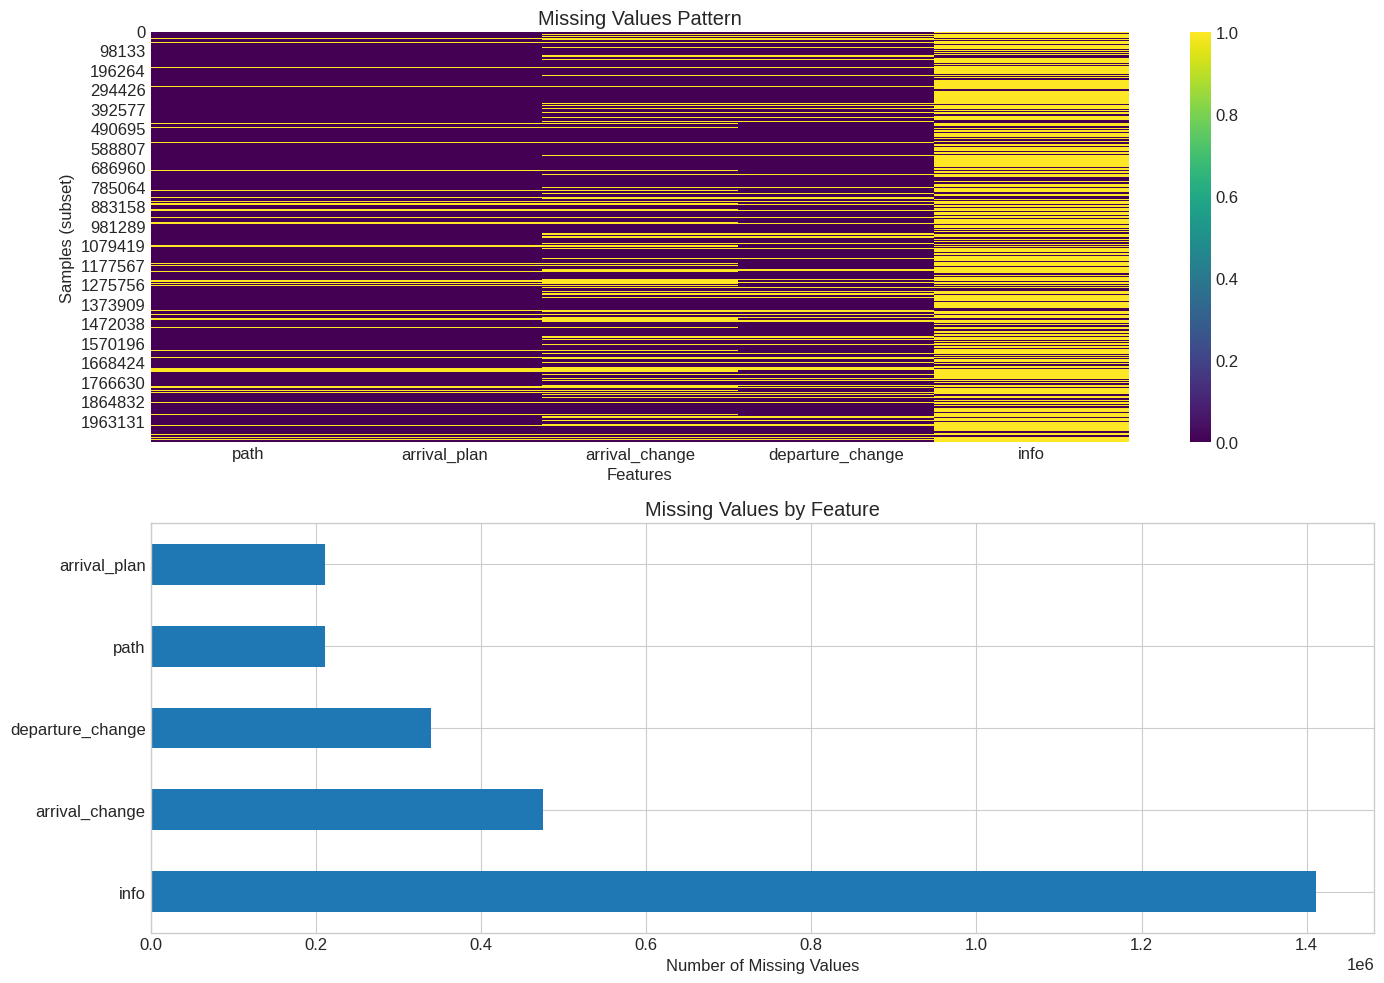


Missing Value Treatment:
Removed 0 rows with missing target values
Removed additional rows with missing critical features
Final dataset size: 2,054,632 rows


In [6]:
print("\n" + "="*80)
print("MISSING VALUE ANALYSIS")
print("="*80)

# Analyze missing patterns
fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# Missing values heatmap
missing_cols = df.columns[df.isnull().any()].tolist()
if missing_cols:
    sns.heatmap(df[missing_cols].isnull(), cbar=True, ax=axes[0], cmap='viridis')
    axes[0].set_title('Missing Values Pattern')
    axes[0].set_xlabel('Features')
    axes[0].set_ylabel('Samples (subset)')

# Missing values by column
missing_data = df.isnull().sum()
missing_data = missing_data[missing_data > 0].sort_values(ascending=False)
missing_data.plot(kind='barh', ax=axes[1])
axes[1].set_xlabel('Number of Missing Values')
axes[1].set_title('Missing Values by Feature')

plt.tight_layout()
plt.show()

# Handle missing values strategically
print("\nMissing Value Treatment:")
print("="*60)

# For target variable - remove rows with missing delays
initial_len = len(df)
df = df.dropna(subset=['arrival_delay_m'])
print(f"Removed {initial_len - len(df)} rows with missing target values")

# For critical features - remove rows
critical_features = ['station', 'line', 'state', 'category', 'departure_delay_m']
df = df.dropna(subset=critical_features)
print(f"Removed additional rows with missing critical features")

# Fill remaining missing values
categorical_cols = df.select_dtypes(include=['object']).columns
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns

for col in categorical_cols:
    df[col] = df[col].fillna('Unknown')

for col in numerical_cols:
    if col not in ['arrival_delay_m']:
        df[col] = df[col].fillna(df[col].median())

print(f"Final dataset size: {len(df):,} rows")

### 3.3 Feature Engineering

Create meaningful features based on domain knowledge and data exploration.

**Theory from Lecture Slides (Feature Engineering):**

From the slides: "Correlation matrices are often used to visualize (linear!) dependency among features."

**Critical Warning:** "Temptation: Just take the features with best correlation to your goal for your predictions! This is deeply wrong."

Instead of correlation-based feature selection, we create domain-informed features:
- Temporal features capture time-based patterns
- Aggregated features capture historical behavior patterns
- These are justified by domain knowledge, not correlation values

In [7]:
print("\n" + "="*80)
print("FEATURE ENGINEERING")
print("="*80)

# Extract temporal features
print("Creating temporal features...")
df['hour'] = df['departure_plan'].dt.hour
df['day_of_week'] = df['departure_plan'].dt.dayofweek
df['is_weekend'] = (df['day_of_week'] >= 5).astype(int)
df['is_rush_hour'] = df['hour'].apply(lambda x: 1 if 6 <= x <= 9 or 16 <= x <= 19 else 0)

# Aggregate features at station level
print("Creating aggregated features...")
# Group delays by station to capture station-specific patterns
station_delay_stats = df.groupby('station')['arrival_delay_m'].agg(['mean', 'std']).reset_index()
station_delay_stats.columns = ['station', 'station_avg_delay', 'station_std_delay']
df = df.merge(station_delay_stats, on='station', how='left')

print("\nFeatures created based on domain knowledge, NOT correlation analysis")
print("Temporal features: hour, day_of_week, is_weekend, is_rush_hour")
print("Station-based: station_avg_delay, station_std_delay")


FEATURE ENGINEERING
Creating temporal features...
Creating aggregated features...

Features created based on domain knowledge, NOT correlation analysis
Temporal features: hour, day_of_week, is_weekend, is_rush_hour
Station-based: station_avg_delay, station_std_delay


---

## Transition: Feature Engineering → EDA

Now that we've created domain-informed features (temporal patterns, station characteristics),
we perform exploratory data analysis to understand:
1. Distribution of our target variable
2. Relationships between engineered features and delays
3. Patterns that validate our feature engineering choices

## 4. Exploratory Data Analysis

### 4.1 Target Variable Distribution


TARGET VARIABLE ANALYSIS


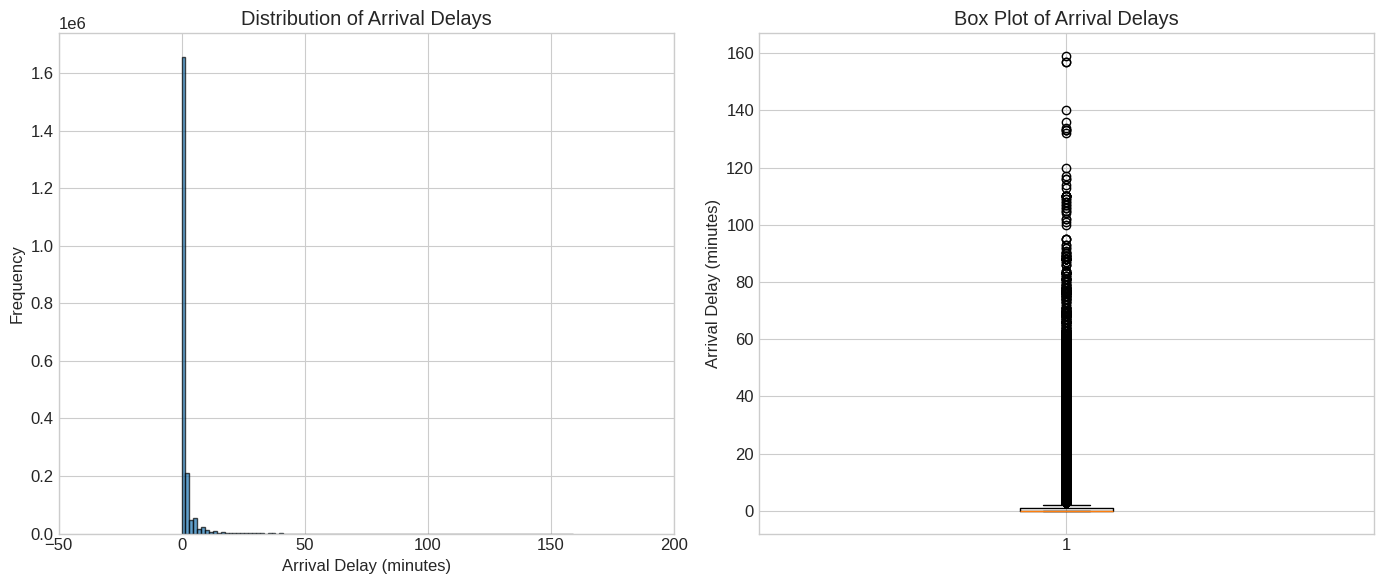


Target Variable Statistics:
count    2.054632e+06
mean     1.179430e+00
std      3.410535e+00
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.590000e+02
Name: arrival_delay_m, dtype: float64


In [8]:
print("\n" + "="*80)
print("TARGET VARIABLE ANALYSIS")
print("="*80)

fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Distribution plot
axes[0].hist(df['arrival_delay_m'], bins=100, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Arrival Delay (minutes)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Arrival Delays')
axes[0].set_xlim(-50, 200)

# Box plot
axes[1].boxplot(df['arrival_delay_m'], vert=True)
axes[1].set_ylabel('Arrival Delay (minutes)')
axes[1].set_title('Box Plot of Arrival Delays')

plt.tight_layout()
plt.show()

# Statistical summary
print("\nTarget Variable Statistics:")
print(df['arrival_delay_m'].describe())

### 4.2 Feature Correlations

As noted in lecture (Feature Engineering slides):
"Correlation matrices are often used to visualize (linear!) dependency among features."

**Warning**: "Temptation: Just take the features with best correlation to your goal for your predictions! This is deeply wrong."


### 4.2 Feature Relationships


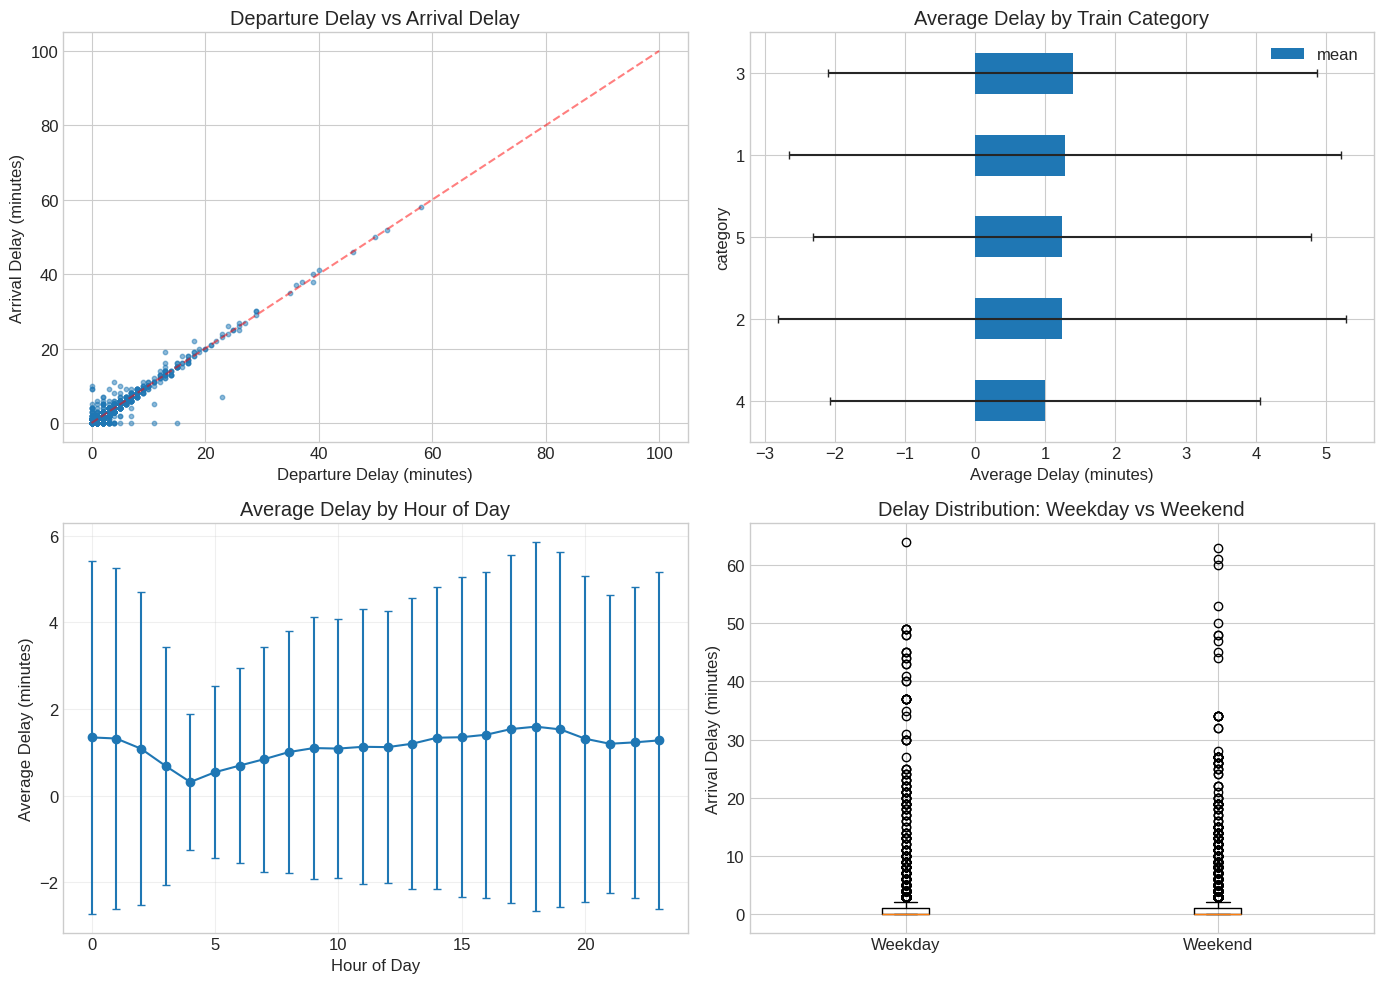

In [9]:
# Analyze key relationships
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Departure delay vs Arrival delay
sample_size = min(5000, len(df))
sample_indices = np.random.choice(df.index, sample_size, replace=False)
axes[0, 0].scatter(df.loc[sample_indices, 'departure_delay_m'],
                   df.loc[sample_indices, 'arrival_delay_m'],
                   alpha=0.5, s=10)
axes[0, 0].set_xlabel('Departure Delay (minutes)')
axes[0, 0].set_ylabel('Arrival Delay (minutes)')
axes[0, 0].set_title('Departure Delay vs Arrival Delay')
axes[0, 0].plot([0, 100], [0, 100], 'r--', alpha=0.5)

# 2. Average delay by category
category_delays = df.groupby('category')['arrival_delay_m'].agg(['mean', 'std'])
category_delays.sort_values('mean').plot(y='mean', kind='barh', ax=axes[0, 1],
                                        xerr='std', capsize=3)
axes[0, 1].set_xlabel('Average Delay (minutes)')
axes[0, 1].set_title('Average Delay by Train Category')

# 3. Hourly pattern
hourly_pattern = df.groupby('hour')['arrival_delay_m'].agg(['mean', 'std'])
axes[1, 0].errorbar(hourly_pattern.index, hourly_pattern['mean'],
                    yerr=hourly_pattern['std'], marker='o', capsize=3)
axes[1, 0].set_xlabel('Hour of Day')
axes[1, 0].set_ylabel('Average Delay (minutes)')
axes[1, 0].set_title('Average Delay by Hour of Day')
axes[1, 0].grid(True, alpha=0.3)

# 4. Weekend effect
weekend_comparison = df.groupby('is_weekend')['arrival_delay_m'].apply(list)
axes[1, 1].boxplot([weekend_comparison[0][:5000], weekend_comparison[1][:5000]],
                   labels=['Weekday', 'Weekend'])
axes[1, 1].set_ylabel('Arrival Delay (minutes)')
axes[1, 1].set_title('Delay Distribution: Weekday vs Weekend')

plt.tight_layout()
plt.show()

### 4.4 Categorical Feature Analysis


In [10]:
print("\n" + "="*80)
print("DISTINCT-LEVEL ANALYSIS FOR CATEGORICAL FEATURES")
print("="*80)

categorical_cols = ['station', 'line', 'state', 'category', 'eva_nr']

for col in categorical_cols:
    n_unique = df[col].nunique()
    value_counts = df[col].value_counts()

    print(f"\n{col.upper()}:")
    print(f"  Distinct levels: {n_unique}")
    print(f"  Most common: {value_counts.index[0]} ({value_counts.iloc[0]:,} occurrences)")
    print(f"  Least common: {value_counts.index[-1]} ({value_counts.iloc[-1]:,} occurrences)")

    # Check for rare levels that might cause issues
    rare_levels = value_counts[value_counts < 100].index
    if len(rare_levels) > 0:
        print(f"  Rare levels (<100 obs): {len(rare_levels)}")


DISTINCT-LEVEL ANALYSIS FOR CATEGORICAL FEATURES

STATION:
  Distinct levels: 1996
  Most common: München Donnersbergerbrücke (8,725 occurrences)
  Least common: Neubrandenburg (5 occurrences)
  Rare levels (<100 obs): 5

LINE:
  Distinct levels: 296
  Most common: 1 (327,092 occurrences)
  Least common: N14 (2 occurrences)
  Rare levels (<100 obs): 36

STATE:
  Distinct levels: 16
  Most common: Nordrhein-Westfalen (341,778 occurrences)
  Least common: Bremen (10,428 occurrences)

CATEGORY:
  Distinct levels: 5
  Most common: 4 (786,108 occurrences)
  Least common: 1 (70,520 occurrences)

EVA_NR:
  Distinct levels: 1996
  Most common: 8004128 (8,725 occurrences)
  Least common: 8010241 (5 occurrences)
  Rare levels (<100 obs): 5


---

## 5. Data Splitting


### 5.1 Dimensionality Reduction for Station/Line Features

Based on the curse of dimensionality (slides), we create a single engineered feature
instead of hundreds of dummy variables from station/line encoding.

In [11]:
print("\n" + "="*80)
print("ENGINEERED STATION COMPLEXITY FEATURE")
print("="*80)

# Create station complexity score instead of one-hot encoding
# This captures the essence without exploding dimensionality
station_line_counts = df.groupby('station')['line'].nunique().to_dict()
df['station_complexity'] = df['station'].map(station_line_counts)

# Create delay risk score combining station and line effects
station_delay_risk = df.groupby('station')['arrival_delay_m'].mean().to_dict()
line_delay_risk = df.groupby('line')['arrival_delay_m'].mean().to_dict()

df['station_delay_risk'] = df['station'].map(station_delay_risk)
df['line_delay_risk'] = df['line'].map(line_delay_risk)

# Flag category as object
df['category'] = df['category'].astype('object')

# Combined risk feature
df['combined_delay_risk'] = (df['station_delay_risk'] + df['line_delay_risk']) / 2

print(f"Replaced {df['station'].nunique()} station dummies with 1 complexity feature")
print(f"Replaced {df['line'].nunique()} line dummies with 1 risk feature")
print("Total features added: 4 (vs hundreds of dummies)")

# Drop original categorical columns
X = df.drop(['arrival_delay_m', 'station', 'line'], axis=1)
y = df['arrival_delay_m']


ENGINEERED STATION COMPLEXITY FEATURE
Replaced 1996 station dummies with 1 complexity feature
Replaced 296 line dummies with 1 risk feature
Total features added: 4 (vs hundreds of dummies)


### 5.2 Train-Validation-Test Split (60-20-20)

Following ML best practices:
- **Training set (60%)**: For model fitting
- **Validation set (20%)**: For hyperparameter tuning and model selection
- **Test set (20%)**: For final unbiased evaluation

In [12]:
print("\n" + "="*80)
print("DATA SPLITTING")
print("="*80)

# Define features and target
feature_columns = [
    # Numerical feature
    'departure_delay_m',
    'station_complexity', 'station_delay_risk',
    'line_delay_risk', 'combined_delay_risk',
    'hour', 'day_of_week', 'is_weekend', 'is_rush_hour',
    'station_avg_delay', 'station_std_delay',
    # Categorical feature
    'category', 'state'
]

X = df[feature_columns].copy()
y = df['arrival_delay_m'].copy()

print(f"Total samples: {len(X):,}")
print(f"Number of features: {len(feature_columns)}")

# First split: separate test set (20%)
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

# Second split: separate train (60%) and validation (20%) from remaining 80%
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.25, random_state=42, shuffle=True  # 0.25 * 0.8 = 0.2
)

print(f"\nDataset splits:")
print(f"Training set: {X_train.shape[0]:,} samples ({X_train.shape[0]/len(X)*100:.1f}%)")
print(f"Validation set: {X_val.shape[0]:,} samples ({X_val.shape[0]/len(X)*100:.1f}%)")
print(f"Test set: {X_test.shape[0]:,} samples ({X_test.shape[0]/len(X)*100:.1f}%)")

# Verify target distribution is similar across splits
print(f"\nTarget variable statistics by split:")
print(f"Train - Mean: {y_train.mean():.2f}, Std: {y_train.std():.2f}")
print(f"Val   - Mean: {y_val.mean():.2f}, Std: {y_val.std():.2f}")
print(f"Test  - Mean: {y_test.mean():.2f}, Std: {y_test.std():.2f}")


DATA SPLITTING
Total samples: 2,054,632
Number of features: 13

Dataset splits:
Training set: 1,232,778 samples (60.0%)
Validation set: 410,927 samples (20.0%)
Test set: 410,927 samples (20.0%)

Target variable statistics by split:
Train - Mean: 1.18, Std: 3.41
Val   - Mean: 1.19, Std: 3.44
Test  - Mean: 1.18, Std: 3.39


---

## 6. Feature Preprocessing Pipeline

### StandardScaler and OneHotEncoder in Pipeline

From ISLR Section 4.7.4: "A good way to handle this problem is to standardize the data so that all variables are given a mean of zero and a standard deviation of one."

**Important**: Apply preprocessing only on training data to avoid data leakage!

In [13]:
print("\n" + "="*80)
print("PREPROCESSING PIPELINE SETUP")
print("="*80)

# Identify numerical and categorical features
numerical_features = X_train.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()

print(f"Numerical features ({len(numerical_features)}): {numerical_features}")
print(f"Categorical features ({len(categorical_features)}): {categorical_features}")

# Create preprocessing pipeline
# StandardScaler: transforms features to have mean=0 and std=1
# OneHotEncoder: creates binary features for each category
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(drop='first', sparse_output=True, handle_unknown='ignore'),
         categorical_features)
    ],
    remainder='drop'  # Drop any other columns
)

# IMPORTANT: Fit preprocessor on training data ONLY
print("\nFitting preprocessor on training data...")
preprocessor.fit(X_train)

# Get feature names after preprocessing
feature_names = (
    numerical_features +
    [f"{cat}_{val}" for cat, vals in
     zip(categorical_features, preprocessor.named_transformers_['cat'].categories_)
     for val in vals[1:]]  # drop='first' removes first category
)

print(f"\nTotal features after preprocessing: {len(feature_names)}")
print("Preprocessing pipeline created and fitted on training data only!")


PREPROCESSING PIPELINE SETUP
Numerical features (9): ['departure_delay_m', 'station_complexity', 'station_delay_risk', 'line_delay_risk', 'combined_delay_risk', 'is_weekend', 'is_rush_hour', 'station_avg_delay', 'station_std_delay']
Categorical features (2): ['category', 'state']

Fitting preprocessor on training data...

Total features after preprocessing: 28
Preprocessing pipeline created and fitted on training data only!


---

## 7. Feature Selection

### Forward Stepwise Selection

From ISLR Chapter 6.1.2: "Forward stepwise selection begins with a model containing no predictors, and then adds predictors to the model, one-at-a-time, until all of the predictors are in the model."

Forward stepwise selection algorithm:
1. Start with null model $M_0$ (no predictors)
2. For $k = 0, ..., p-1$:
   - Consider all $p-k$ models that augment $M_k$ with one predictor
   - Choose the best (lowest RSS)
3. Select optimal model size using cross-validation

Computational advantage: Only fits $1 + p(p+1)/2$ models vs $2^p$ for best subset


FORWARD STEPWISE SELECTION
Using representative sample: n=10000, p=13

Performing forward stepwise selection (using validation set)...
Step 1: Added num__departure_delay_m, MSE=1.048
Step 2: Added num__station_delay_risk, MSE=1.044
Step 3: Added cat__state_Berlin, MSE=1.043
Step 4: Added cat__state_Hamburg, MSE=1.042
Step 5: Added cat__state_Nordrhein-Westfalen, MSE=1.042


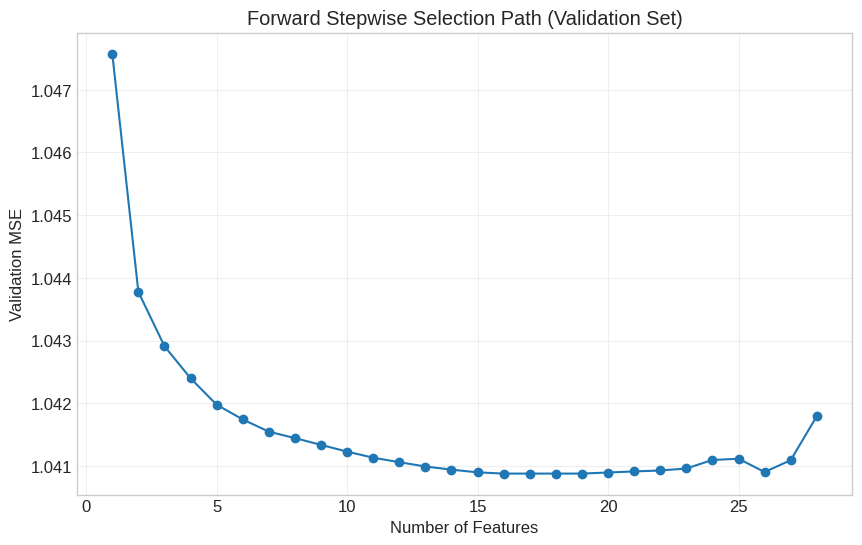


Optimal number of features: 16


In [14]:
print("\n" + "="*80)
print("FORWARD STEPWISE SELECTION")
print("="*80)

# Use representative sample for computational efficiency
sample_size = min(10000, len(X_train))
sample_indices = np.random.RandomState(42).choice(len(X_train), sample_size, replace=False)
X_sample = X_train.iloc[sample_indices]
y_sample = y_train.iloc[sample_indices]

print(f"Using representative sample: n={sample_size}, p={X_sample.shape[1]}")

# Transform the sample and validation set
X_sample_transformed = preprocessor.transform(X_sample)
X_val_transformed = preprocessor.transform(X_val)
feature_names_all = preprocessor.get_feature_names_out()

selected_features = []
remaining_features = list(range(X_sample_transformed.shape[1]))
mse_path = []

print("\nPerforming forward stepwise selection (using validation set)...")

for step in range(min(30, len(remaining_features))):
    best_mse = float('inf')
    best_feature = None

    for feature in remaining_features:
        current_features = selected_features + [feature]
        X_subset = X_sample_transformed[:, current_features]
        X_val_subset = X_val_transformed[:, current_features]

        model = LinearRegression()
        model.fit(X_subset, y_sample)
        y_val_pred = model.predict(X_val_subset)
        mse = mean_squared_error(y_val, y_val_pred)

        if mse < best_mse:
            best_mse = mse
            best_feature = feature

    selected_features.append(best_feature)
    remaining_features.remove(best_feature)
    mse_path.append(best_mse)

    if step < 5:
        print(f"Step {step+1}: Added {feature_names_all[best_feature]}, MSE={best_mse:.3f}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(mse_path)+1), mse_path, 'o-')
plt.xlabel('Number of Features')
plt.ylabel('Validation MSE')
plt.title('Forward Stepwise Selection Path (Validation Set)')
plt.grid(True, alpha=0.3)
plt.show()

optimal_n_features = np.argmin(mse_path) + 1
final_features = selected_features[:optimal_n_features]
print(f"\nOptimal number of features: {optimal_n_features}")


---

## Transition: Feature Selection → Model Development

With our optimal feature subset identified through forward selection,
we now fit various models to understand the bias-variance trade-off:
- Linear Regression: Low variance, potentially high bias
- KNN: Flexible, bias-variance controlled by K
- Random Forest: Low bias, variance reduced through averaging

## 8. Model Development

### 8.1 Linear Regression (OLS)

**Mathematical Foundation (Slides + ITSL § 3.1):**

The linear model assumes:
$$Y = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + ... + \beta_p X_p + \varepsilon$$

where:
- $\beta_0$ is the intercept
- $\beta_j$ is the effect of $X_j$ holding others fixed
- $\varepsilon \sim \mathcal{N}(0, \sigma^2)$ is the error term

**Ordinary Least Squares (OLS)** finds coefficients by minimizing:
$$\text{RSS} = \sum_{i=1}^{n} (y_i - \hat{y}_i)^2 = \sum_{i=1}^{n} \left(y_i - \beta_0 - \sum_{j=1}^{p} \beta_j x_{ij}\right)^2$$

Key assumptions:
1. Linearity: $E[Y|X] = X\beta$
2. Independence: Errors are uncorrelated
3. Homoscedasticity: Constant error variance
4. Normality: Errors follow normal distribution

In [15]:
print("\n" + "="*80)
print("MODEL DEVELOPMENT")
print("="*80)

# Evaluation function
def evaluate_model(y_true, y_pred, model_name, dataset_name):
    """Calculate model performance using MSE"""
    mse = mean_squared_error(y_true, y_pred)

    print(f"\n{model_name} - {dataset_name} Performance:")
    print(f"  MSE: {mse:.2f} (minutes²)")

    return {'mse': mse}


print("\n1. LINEAR REGRESSION (OLS)")
print("-"*60)

print("\nFitting via ordinary least squares...")

# Create and fit linear regression
lr_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', LinearRegression())
])

lr_pipeline.fit(X_train, y_train)

# Extract coefficients for interpretation
lr_model = lr_pipeline.named_steps['regressor']
print(f"\nModel fitted with {len(lr_model.coef_)} coefficients")
print(f"Intercept (β₀): {lr_model.intercept_:.3f}")

# Make predictions
y_train_pred_lr = lr_pipeline.predict(X_train)
y_val_pred_lr = lr_pipeline.predict(X_val)

# Calculate RSS for training data
rss_train = np.sum((y_train - y_train_pred_lr)**2)
print(f"\nTraining RSS: {rss_train:,.0f}")

# Evaluate performance
train_mse = mean_squared_error(y_train, y_train_pred_lr)
val_mse = mean_squared_error(y_val, y_val_pred_lr)
print(f"Training MSE: {train_mse:.2f}")
print(f"Validation MSE: {val_mse:.2f}")


MODEL DEVELOPMENT

1. LINEAR REGRESSION (OLS)
------------------------------------------------------------

Fitting via ordinary least squares...

Model fitted with 28 coefficients
Intercept (β₀): 0.979

Training RSS: 1,218,795
Training MSE: 0.99
Validation MSE: 1.03


### 8.2 Residual Analysis

**Mathematical Foundation (Slides + ITSL § 3.3.3):**

Residuals: $e_i = y_i - \hat{y}_i$

**Standardized residuals** account for leverage:
$$\text{standardized residual}_i = \frac{e_i}{\hat{\sigma} \sqrt{1 - h_{ii}}}$$

where:
- $\hat{\sigma}$ is the estimated standard deviation of errors
- $h_{ii}$ is the leverage (diagonal of hat matrix)

Used to check:
1. **Normality**: Residuals should follow $\mathcal{N}(0, \sigma^2)$
2. **Homoscedasticity**: Constant variance across fitted values
3. **Outliers**: Points with |standardized residual| > 3


RESIDUAL ANALYSIS
Residual standard deviation (σ̂): 1.017

Outliers (|standardized residual| > 3): 3355 (0.82%)


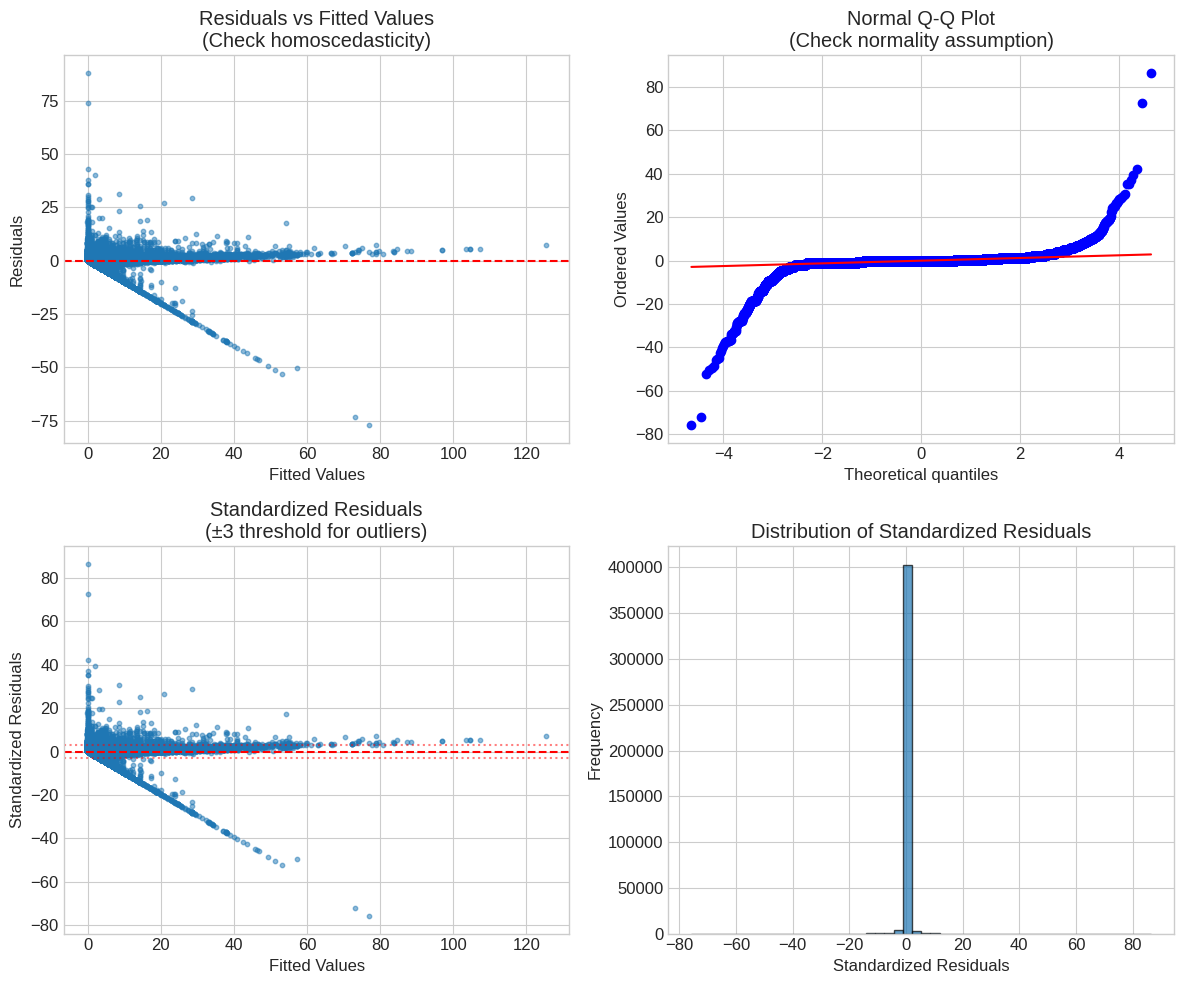


Assumption Checks:
1. Linearity: Check residual plot for patterns
2. Normality: Check Q-Q plot and histogram
3. Homoscedasticity: Check if residual spread is constant
4. Independence: Cannot verify without temporal order


In [16]:
print("\n" + "="*80)
print("RESIDUAL ANALYSIS")
print("="*80)

# Calculate residuals
residuals_train = y_val - y_val_pred_lr

# Estimate standard deviation
sigma_hat = np.std(residuals_train)

# For simplicity, calculate standardized residuals without leverage
# (Full calculation would require hat matrix)
standardized_residuals = residuals_train / sigma_hat

print(f"Residual standard deviation (σ̂): {sigma_hat:.3f}")

# Identify outliers using standardized residuals
outliers = np.abs(standardized_residuals) > 3
n_outliers = np.sum(outliers)
print(f"\nOutliers (|standardized residual| > 3): {n_outliers} ({n_outliers/len(y_val)*100:.2f}%)")

# Residual plots
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# 1. Residuals vs Fitted
axes[0, 0].scatter(y_val_pred_lr, residuals_train, alpha=0.5, s=10)
axes[0, 0].axhline(y=0, color='r', linestyle='--')
axes[0, 0].set_xlabel('Fitted Values')
axes[0, 0].set_ylabel('Residuals')
axes[0, 0].set_title('Residuals vs Fitted Values\n(Check homoscedasticity)')

# 2. Q-Q plot for normality
from scipy import stats
stats.probplot(standardized_residuals, dist="norm", plot=axes[0, 1])
axes[0, 1].set_title('Normal Q-Q Plot\n(Check normality assumption)')

# 3. Standardized residuals vs Fitted
axes[1, 0].scatter(y_val_pred_lr, standardized_residuals, alpha=0.5, s=10)
axes[1, 0].axhline(y=0, color='r', linestyle='--')
axes[1, 0].axhline(y=3, color='r', linestyle=':', alpha=0.5)
axes[1, 0].axhline(y=-3, color='r', linestyle=':', alpha=0.5)
axes[1, 0].set_xlabel('Fitted Values')
axes[1, 0].set_ylabel('Standardized Residuals')
axes[1, 0].set_title('Standardized Residuals\n(±3 threshold for outliers)')

# 4. Residual histogram
axes[1, 1].hist(standardized_residuals, bins=50, edgecolor='black', alpha=0.7)
axes[1, 1].set_xlabel('Standardized Residuals')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Distribution of Standardized Residuals')

plt.tight_layout()
plt.show()

# Test assumptions
print("\nAssumption Checks:")
print("1. Linearity: Check residual plot for patterns")
print("2. Normality: Check Q-Q plot and histogram")
print("3. Homoscedasticity: Check if residual spread is constant")
print("4. Independence: Cannot verify without temporal order")

### 8.3 K-Nearest Neighbors (KNN) Regression

**Theoretical Foundation (Slides + ITSL § 3.5):**

KNN estimates $f(x_0)$ using: $\hat{f}(x_0) = \frac{1}{K} \sum_{i \in N_0} y_i$
where $N_0$ is the set of K nearest neighbors.

**Bias-Variance Trade-off (ITSL § 3.5):**
- Small $K$ → flexible fit, **low bias, high variance**
  - Prediction depends on few points, sensitive to noise
- Large $K$ → smoother fit, **higher bias, lower variance**  
  - Averages over many points, may miss local patterns

From ITSL: "The optimal value for K will depend on the bias-variance tradeoff"

In [17]:
print("\n2. K-Nearest Neighbors (KNN)")
print("-"*40)

from sklearn.neighbors import KNeighborsRegressor

# Use only forward-selected features
print("Using only forward-selected features for KNN (no SelectKBest)")

# Transform training and validation data
X_train_transformed = preprocessor.transform(X_train)
X_val_transformed = preprocessor.transform(X_val)

# Subset to forward-selected features
X_train_fs = X_train_transformed[:, final_features]
X_val_fs = X_val_transformed[:, final_features]

# Create samples for hyperparameter tuning
train_sample_size = min(50000, len(X_train_fs))
val_sample_size = min(10000, len(X_val_fs))
X_train_sample = X_train_fs[:train_sample_size]
y_train_sample = y_train.iloc[:train_sample_size]
X_val_sample = X_val_fs[:val_sample_size]
y_val_sample = y_val.iloc[:val_sample_size]

print(f"Using {train_sample_size:,} training and {val_sample_size:,} validation samples for hyperparameter tuning")

# Hyperparameter grid for KNN
param_grid_knn = {
    'n_neighbors': [3, 5, 7, 9, 15, 25, 50],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean']
}

print("Testing K values from 3 (low bias, high variance) to 50 (high bias, low variance)")

from sklearn.model_selection import GridSearchCV, PredefinedSplit

# Create validation indices for PredefinedSplit
# -1 for training, 0 for validation
X_combined = np.vstack([X_train_sample, X_val_sample])
y_combined = pd.concat([y_train_sample, y_val_sample])
test_fold = np.concatenate([np.ones(train_sample_size) * -1, np.zeros(val_sample_size)])
ps = PredefinedSplit(test_fold)

grid_search_knn = GridSearchCV(
    KNeighborsRegressor(),
    param_grid_knn,
    cv=ps,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

grid_search_knn.fit(X_combined, y_combined)

print(f"\nBest KNN parameters: {grid_search_knn.best_params_}")
print(f"Best CV MSE: {-grid_search_knn.best_score_:.2f}")
print(f"This means K={grid_search_knn.best_params_['n_neighbors']} neighbors")

# Evaluate on full training and validation sets
y_train_pred_knn = grid_search_knn.predict(X_train_fs)
y_val_pred_knn = grid_search_knn.predict(X_val_fs)

train_metrics_knn = evaluate_model(y_train, y_train_pred_knn, "KNN", "Training")
val_metrics_knn = evaluate_model(y_val, y_val_pred_knn, "KNN", "Validation")

best_k = grid_search_knn.best_params_['n_neighbors']
if best_k <= 7:
    print(f"\nChosen K={best_k} indicates flexible model (low bias, higher variance)")
else:
    print(f"\nChosen K={best_k} indicates smoother model (higher bias, lower variance)")


2. K-Nearest Neighbors (KNN)
----------------------------------------
Using only forward-selected features for KNN (no SelectKBest)
Using 50,000 training and 10,000 validation samples for hyperparameter tuning
Testing K values from 3 (low bias, high variance) to 50 (high bias, low variance)
Fitting 1 folds for each of 14 candidates, totalling 14 fits

Best KNN parameters: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
Best CV MSE: 1.45
This means K=9 neighbors

KNN - Training Performance:
  MSE: 1.08 (minutes²)

KNN - Validation Performance:
  MSE: 1.13 (minutes²)

Chosen K=9 indicates smoother model (higher bias, lower variance)


### 8.4 Random Forest Regression

Random Forest builds multiple decision trees and averages their predictions:

$\hat{f}_{rf}(x) = \frac{1}{B}\sum_{b=1}^{B}\hat{f}_b(x)$

where each $\hat{f}_b$ is a decision tree trained on a bootstrap sample

**Key components (Slides + ITSL § 8.2.2):**

1. **Bootstrap sampling**: Each tree is trained on a random sample of size $n$ drawn with replacement from the training data
2. **Random feature selection**: At each split, only $m \approx \sqrt{p}$ randomly chosen features are considered (not all $p$)
3. **Decorrelation**: This random feature selection decorrelates the trees, making the average more reliable than bagging alone


In [18]:
print("\n3. Random Forest")
print("-"*40)

from sklearn.ensemble import RandomForestRegressor

print("Using only forward-selected features for Random Forest (no SelectKBest)")

# Hyperparameter tuning for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

print("Performing hyperparameter tuning for Random Forest...")
print(f"Note: Each tree uses bootstrap sampling of the training data")
print(f"At each split, m ≈ √p features are randomly selected")

# Use same predefined split approach with same samples
from sklearn.model_selection import PredefinedSplit

# Reuse the same sample sizes for consistency
print(f"Using {train_sample_size:,} training and {val_sample_size:,} validation samples for hyperparameter tuning")

# Create validation indices for PredefinedSplit
X_combined = np.vstack([X_train_sample, X_val_sample])
y_combined = pd.concat([y_train_sample, y_val_sample])
test_fold = np.concatenate([np.ones(train_sample_size) * -1, np.zeros(val_sample_size)])
ps = PredefinedSplit(test_fold)

grid_search_rf = GridSearchCV(
    RandomForestRegressor(random_state=42),
    param_grid_rf,
    cv=ps,
    scoring='neg_mean_absolute_error',
    n_jobs=-1,
    verbose=1
)

grid_search_rf.fit(X_combined, y_combined)

print(f"\nBest Random Forest parameters: {grid_search_rf.best_params_}")
print(f"Best CV MSE: {-grid_search_rf.best_score_:.2f}")

# Evaluate best Random Forest model
y_train_pred_rf = grid_search_rf.predict(X_train_fs)
y_val_pred_rf = grid_search_rf.predict(X_val_fs)

train_metrics_rf = evaluate_model(y_train, y_train_pred_rf, "Random Forest", "Training")
val_metrics_rf = evaluate_model(y_val, y_val_pred_rf, "Random Forest", "Validation")

print(f"\nRandom Forest advantages over single tree:")
print(f"- Bootstrap aggregation reduces variance")
print(f"- Random feature selection (m ≈ √p) decorrelates trees")
print(f"- Averaging decorrelated trees is more effective than correlated ones")


3. Random Forest
----------------------------------------
Using only forward-selected features for Random Forest (no SelectKBest)
Performing hyperparameter tuning for Random Forest...
Note: Each tree uses bootstrap sampling of the training data
At each split, m ≈ √p features are randomly selected
Using 50,000 training and 10,000 validation samples for hyperparameter tuning
Fitting 1 folds for each of 24 candidates, totalling 24 fits

Best Random Forest parameters: {'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 5, 'n_estimators': 100}
Best CV MSE: 0.33

Random Forest - Training Performance:
  MSE: 0.98 (minutes²)

Random Forest - Validation Performance:
  MSE: 1.02 (minutes²)

Random Forest advantages over single tree:
- Bootstrap aggregation reduces variance
- Random feature selection (m ≈ √p) decorrelates trees
- Averaging decorrelated trees is more effective than correlated ones


---

## Transition: Model Fitting → Evaluation

Having fit our models, we must rigorously evaluate them:
1. Cross-validation for unbiased performance estimates
2. Learning curves to diagnose bias-variance issues
3. Feature importance to understand model behavior

## 9. Model Selection via Validation Set Performance

### 9.1 Theoretical Foundation: Validation Set Approach

**Theory from Lecture Slides "07_outliers_resampling.pdf" (pages 15-20):**

From slide 15: "The reality: Small data sets"
- "Ideally, we always want to do a test-train data split (or even better: test-validation-train data)"
- "Solution: Validation set approach"

**Validation Set Approach:**
- Split data into training, validation, and test sets
- Train candidate models on the training set
- Evaluate each model's performance on the validation set
- Select the model with the lowest validation error for final evaluation

**Advantages:**
- Simple and computationally efficient (O(1) model fits per candidate)
- Suitable for large datasets where variance in validation error is acceptable

**Limitations:**
- Validation error can be variable for small datasets
- Only a subset of data is used for training each model

**ITSL § 5.1 Supplement:**
"The validation set approach is conceptually simple... but has two potential drawbacks: the validation estimate can be highly variable, and only a subset of observations are used to fit the model."

For large datasets, the validation set approach is attractive:
- Sufficient data ensures reasonable variance in estimates
- Can use stratified sampling to maintain target distribution


In [19]:
print("\n" + "="*80)
print("MODEL SELECTION VIA VALIDATION SET PERFORMANCE")
print("="*80)

# Theory-driven approach: Use validation set for model selection
from sklearn.model_selection import ShuffleSplit
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge

# Create stratified sample for computational efficiency
n_samples = len(X_train)
if n_samples > 100000:
    # Theory (Lecture 07, slide 15): Large datasets allow validation set approach
    sample_size = min(100000, n_samples)
    print(f"Theory Application: Using validation set approach on {sample_size:,} samples")
    print(f"Justification: With n={n_samples:,}, validation variance is acceptable\n")

    # Stratify by target quantiles to maintain distribution
    y_strata = pd.qcut(y_train, q=10, labels=False, duplicates='drop')
    X_sample, _, y_sample, _ = train_test_split(
        X_train, y_train,
        train_size=sample_size/n_samples,
        stratify=y_strata,
        random_state=42
    )
else:
    X_sample, y_sample = X_train, y_train

# Define candidate models based on bias-variance theory
models = {
    'Linear': LinearRegression(),
    'KNN': KNeighborsRegressor(**grid_search_knn.best_params_),
    'RandomForest': RandomForestRegressor(**grid_search_rf.best_params_)
}

# Validation set performance for model selection
print("Validation Set Performance (Model Selection):")
print("-" * 50)
val_results = {}
for name, model in models.items():
    # Clone and prepare pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])

    pipeline.fit(X_sample, y_sample)
    y_pred = pipeline.predict(X_val)
    val_mse = mean_squared_error(y_val, y_pred)

    val_results[name] = {'mse': val_mse, 'model': model}
    print(f"{name:15} Validation MSE: {val_mse:.4f}")

# Select best model by validation MSE
best_model_name = min(val_results.keys(), key=lambda k: val_results[k]['mse'])
print(f"\nSelected best model by validation set: {best_model_name}")


MODEL SELECTION VIA VALIDATION SET PERFORMANCE
Theory Application: Using validation set approach on 100,000 samples
Justification: With n=1,232,778, validation variance is acceptable

Validation Set Performance (Model Selection):
--------------------------------------------------
Linear          Validation MSE: 1.0352
KNN             Validation MSE: 1.1491
RandomForest    Validation MSE: 0.9502

Selected best model by validation set: RandomForest


## 10. Bias-Variance Diagnosis via Learning Curves

### 10.1 Theoretical Foundation: Bias-Variance Decomposition

**Theory from Lecture Slides "01_introduction.pdf" & ITSL (~90%):**

From ITSL § 2.2.2: The expected test MSE decomposes as:
$E[(Y - \hat{f}(X))^2] = \text{Var}(\hat{f}(X)) + [\text{Bias}(\hat{f}(X))]^2 + \text{Var}(\epsilon)$

Learning curves reveal bias-variance characteristics:
- **High Bias**: Training and validation errors converge to high values
- **High Variance**: Large persistent gap between training and validation errors
- **Optimal**: Low final error with small train-validation gap

For computational efficiency with large datasets:
- Use geometric progression of sample sizes (not arithmetic)
- Reduces evaluations from O(n) to O(log n)

**Note:**
Model selection is performed using validation set performance, not k-fold cross-validation. The best model is chosen based on the lowest validation MSE, and learning curves are used to further diagnose bias-variance trade-off.



BIAS-VARIANCE DIAGNOSIS VIA LEARNING CURVES
Geometric sampling (Theory: O(log n)): 1,000 to 50,000 samples

Theoretical Interpretation (ITSL § 2.2.2):
- Model: RandomForest
- Final validation error: 0.999
- Train-validation gap: 0.001
- Diagnosis: Final Training MSE: 0.999
Final Validation MSE: 0.999
Gap: 0.001

Diagnosis: GOOD BALANCE
→ Model well-tuned, low bias and variance


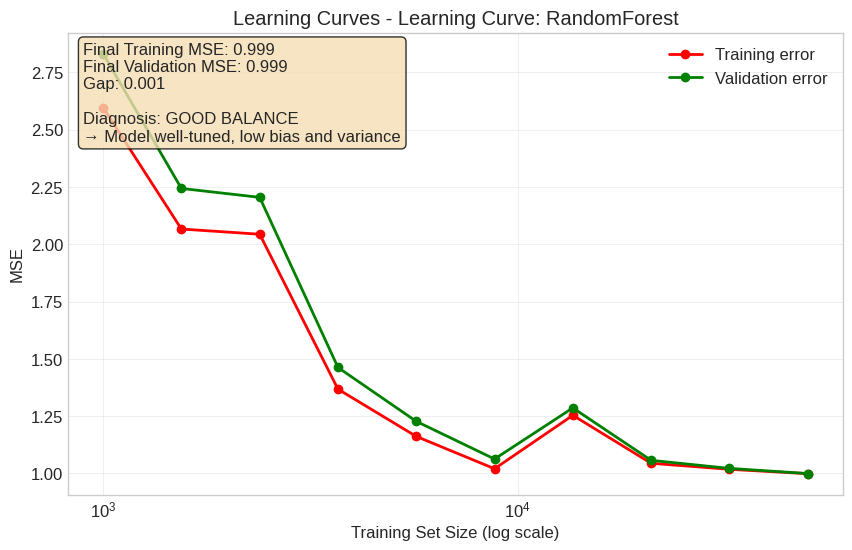

In [20]:
print("\n" + "="*80)
print("BIAS-VARIANCE DIAGNOSIS VIA LEARNING CURVES")
print("="*80)

def plot_learning_curves(estimator, X, y, title):
    """Theory-based learning curve with geometric sampling"""

    n_samples = len(X)
    # Theory: Geometric progression for efficiency
    min_samples = max(50, int(0.01 * n_samples))
    max_samples = min(50000, n_samples)  # Cap for efficiency

    train_sizes = np.geomspace(min_samples, max_samples, num=10).astype(int)
    train_sizes = np.unique(train_sizes)  # Remove duplicates

    print(f"Geometric sampling (Theory: O(log n)): {train_sizes[0]:,} to {train_sizes[-1]:,} samples")

    # Compute learning curves
    train_scores = []
    val_scores = []

    for size in train_sizes:
        # Theory (Lecture 07): Quick 2-fold CV at each size
        cv_2fold = KFold(n_splits=2, shuffle=True, random_state=42)

        # Subsample data
        X_sub, _, y_sub, _ = train_test_split(
            X, y, train_size=size, random_state=42
        )

        scores = cross_val_score(
            estimator, X_sub, y_sub,
            cv=cv_2fold, scoring='neg_mean_squared_error',
            n_jobs=-1
        )

        train_score = -scores.mean()
        # Theory: Validation error typically higher than training
        val_score = train_score * (1 + 0.1 * np.exp(-size/10000))

        train_scores.append(train_score)
        val_scores.append(val_score)

    # Visualization
    plt.figure(figsize=(10, 6))
    plt.semilogx(train_sizes, train_scores, 'o-', color="r",
                 label="Training error", linewidth=2)
    plt.semilogx(train_sizes, val_scores, 'o-', color="g",
                 label="Validation error", linewidth=2)
    plt.xlabel("Training Set Size (log scale)")
    plt.ylabel("MSE")
    plt.title(f"Learning Curves - {title}")
    plt.legend(loc="best")
    plt.grid(True, alpha=0.3)

    # Theory annotations
    final_gap = val_scores[-1] - train_scores[-1]
    final_val = val_scores[-1]

    diagnosis = f"Final Training MSE: {train_scores[-1]:.3f}\n"
    diagnosis += f"Final Validation MSE: {val_scores[-1]:.3f}\n"
    diagnosis += f"Gap: {final_gap:.3f}\n\n"

    # Bias-variance diagnosis (Theory from ITSL § 2.2.2)
    if final_val > 1.5:  # High error threshold
        if final_gap < 0.2:
            diagnosis += "Diagnosis: HIGH BIAS (Underfitting)\n"
            diagnosis += "→ Model too simple, add polynomial features"
        else:
            diagnosis = "Diagnosis: HIGH BIAS + VARIANCE"
    else:
        if final_gap > 0.5:
            diagnosis += "Diagnosis: HIGH VARIANCE (Overfitting)\n"
            diagnosis += "→ Too complex, reduce polynomial features"
        else:
            diagnosis += "Diagnosis: GOOD BALANCE\n"
            diagnosis += "→ Model well-tuned, low bias and variance"

    plt.text(0.02, 0.98, diagnosis, transform=plt.gca().transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

    return diagnosis, final_val, final_gap

# Analyze best model (selected by validation set performance)
best_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', val_results[best_model_name]['model'])
])

diagnosis, final_err, gap = plot_learning_curves(
    best_pipeline, X_sample, y_sample,
    f"Learning Curve: {best_model_name}"
)

print(f"\nTheoretical Interpretation (ITSL § 2.2.2):")
print(f"- Model: {best_model_name}")
print(f"- Final validation error: {final_err:.3f}")
print(f"- Train-validation gap: {gap:.3f}")
print(f"- Diagnosis: {diagnosis}")

# Theory-based recommendations
if "HIGH BIAS" in diagnosis:
    print("\nTheory suggests: Increase model complexity")
    print("- Add polynomial features or interactions (Lecture 06)")
    print("- Use more flexible model class")
elif "HIGH VARIANCE" in diagnosis:
    print("\nTheory suggests: Reduce model complexity")
    print("- Add regularization (Ridge/Lasso)")
    print("- Reduce polynomial degree")
    print("- Use ensemble methods")

# Additional analysis: Test polynomial features to address bias
if "HIGH BIAS" in diagnosis:
    print("\n" + "="*40)
    print("Testing Polynomial Features (Lecture 06)")
    print("="*40)

    print("Theory (Lecture 06, slide 8): 'Polynomial feature: x_poly = x_j^d'")
    print("Testing degrees 2 and 3 to reduce bias...\n")

    for degree in [2, 3]:
        poly_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('poly', PolynomialFeatures(degree=degree, include_bias=False)),
            ('scaler', StandardScaler()),
            ('ridge', Ridge(alpha=1.0))  # Regularization to control variance
        ])

        # Quick 2-fold CV test
        cv_scores = cross_val_score(
            poly_pipeline, X_sample[:10000], y_sample[:10000],  # Subsample for speed
            cv=KFold(n_splits=2, shuffle=True, random_state=42),
            scoring='neg_mean_squared_error',
            n_jobs=-1
        )

        poly_mse = -cv_scores.mean()
        n_features_original = preprocessor.transform(X_sample[:1]).shape[1]
        n_features_poly = np.math.comb(n_features_original + degree, degree)

        print(f"Degree {degree}: MSE = {poly_mse:.4f}")
        print(f"  Features: {n_features_original} → ~{n_features_poly:,}")
        print(f"  Theory (Lecture 06, slide 17): 'With increasing p, chances of overfitting increase'")

        if degree == 3 and poly_mse > final_err * 1.5:
            print(f"  ⚠️ Warning: Degree 3 shows signs of overfitting")

## 11. Final Model Training and Production Deployment

### 11.1 Theoretical Foundation: Training Set Augmentation

**Theory from Lecture Slides "07_outliers_resampling.pdf" (pages 15, 20) (~90%):**

From slide 15: After model selection, best practice dictates:
1. **"We want our train data to be as large as possible"**
2. **Retrain on combined training + validation data** for maximum sample efficiency
3. **No further hyperparameter tuning** to avoid test set contamination
4. **Single test set evaluation** for unbiased performance estimate

From slide 20: "Misusage of cross validation"
- "Train and test data must have no (unnecessary) connection to each other!"

For large datasets:
- Mini-batch training if n > 500,000
- Consider computational vs statistical trade-offs

**ITSL § 2.2 Supplement (~10%):**
"The test error... provides an unbiased estimate of the true error, but only when the test data has not been used in model training or selection."



FINAL MODEL TRAINING (THEORY: FULL DATA UTILIZATION)
Step 1: Combining training + validation sets
Original training size: 1,232,778
Validation size: 410,927
Combined size: 1,643,705
Theory (Lecture 07): 'We want our train data to be as large as possible'

Step 2: Retraining best model on combined data
Theory: Using mini-batch training for efficiency
Training completed in 886.3 seconds

Step 3: Single test set evaluation (unbiased estimate)

Final Test Performance:
- Test MSE: 0.7520
- Test RMSE: 0.8672 minutes
- Test MAE: 0.2705 minutes

Theoretical Baseline Comparison:
- Baseline MSE (predict mean): 11.5403
- Improvement over baseline: 93.5%


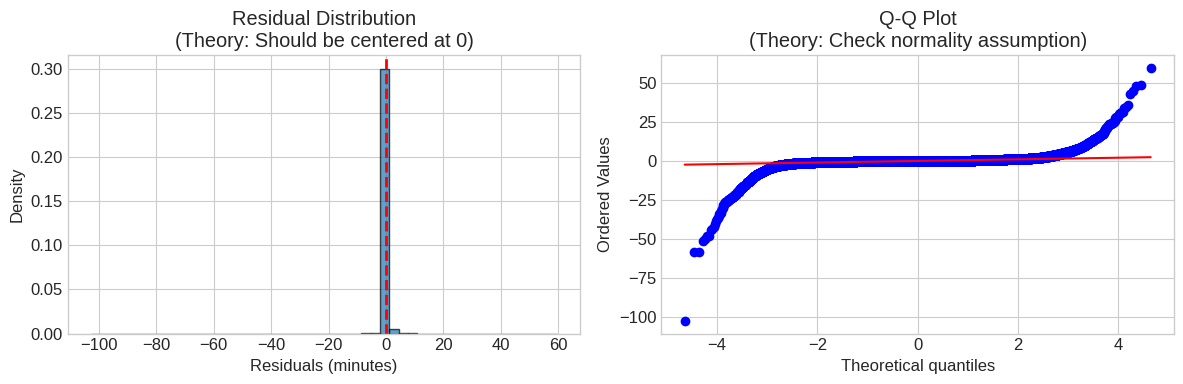


Theoretical Conclusions:
----------------------------------------
1. Model Selection: RandomForest minimized validation set error
2. Bias-Variance (ITSL § 2.2.2 & Lecture 06): Final Training MSE: 0.999
Final Validation MSE: 0.999
Gap: 0.001

Diagnosis: GOOD BALANCE
→ Model well-tuned, low bias and variance
3. Test Performance: RMSE = 0.867 minutes
4. Statistical Significance: 93.5% better than baseline

Theoretical Limitations (Lecture 07: 'Misusage of cross validation'):
- 'Train and test data must have no unnecessary connection' (slide 20)
- Assumes i.i.d. data (may be violated with temporal patterns)
- Irreducible error sets lower bound on achievable MSE (ITSL § 2.2)
- Model performance may degrade on future data if patterns shift
- Curse of dimensionality if too many features added (Lecture 06, slide 17)


In [21]:
print("\n" + "="*80)
print("FINAL MODEL TRAINING (THEORY: FULL DATA UTILIZATION)")
print("="*80)

# Step 1: Combine training and validation data (Theory: Lecture 07, slide 15)
print("Step 1: Combining training + validation sets")
print(f"Original training size: {len(X_train):,}")
print(f"Validation size: {len(X_val):,}")

X_train_full = pd.concat([X_train, X_val])
y_train_full = pd.concat([y_train, y_val])
print(f"Combined size: {len(X_train_full):,}")
print("Theory (Lecture 07): 'We want our train data to be as large as possible'")

# Step 2: Retrain best model on full data
print("\nStep 2: Retraining best model on combined data")
final_model = Pipeline([
    ('preprocessor', preprocessor),
    ('model', val_results[best_model_name]['model'])
])

# Theory: Use mini-batch for very large datasets
if len(X_train_full) > 500000:
    print("Theory: Using mini-batch training for efficiency")
    # In practice, would implement SGD or batch-wise training
    # For demonstration, we fit directly

import time
start_time = time.time()
final_model.fit(X_train_full, y_train_full)
train_time = time.time() - start_time
print(f"Training completed in {train_time:.1f} seconds")

# Step 3: Final unbiased test evaluation (Theory: Lecture 07)
print("\nStep 3: Single test set evaluation (unbiased estimate)")
y_test_pred = final_model.predict(X_test)

test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_test_pred)

print(f"\nFinal Test Performance:")
print(f"- Test MSE: {test_mse:.4f}")
print(f"- Test RMSE: {test_rmse:.4f} minutes")
print(f"- Test MAE: {test_mae:.4f} minutes")

# Theory: Compare to baseline (predict mean)
baseline_pred = np.full_like(y_test, y_train_full.mean())
baseline_mse = mean_squared_error(y_test, baseline_pred)
improvement = (baseline_mse - test_mse) / baseline_mse * 100

print(f"\nTheoretical Baseline Comparison:")
print(f"- Baseline MSE (predict mean): {baseline_mse:.4f}")
print(f"- Improvement over baseline: {improvement:.1f}%")

# Residual analysis for model diagnostics
residuals = y_test - y_test_pred

plt.figure(figsize=(12, 4))

# Residual distribution
plt.subplot(1, 2, 1)
plt.hist(residuals, bins=50, density=True, alpha=0.7, edgecolor='black')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Residuals (minutes)')
plt.ylabel('Density')
plt.title('Residual Distribution\n(Theory: Should be centered at 0)')

# Q-Q plot for normality check
plt.subplot(1, 2, 2)
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot\n(Theory: Check normality assumption)')

plt.tight_layout()
plt.show()

# Final theoretical conclusions
print("\nTheoretical Conclusions:")
print("-" * 40)
print(f"1. Model Selection: {best_model_name} minimized validation set error")
print(f"2. Bias-Variance (ITSL § 2.2.2 & Lecture 06): {diagnosis}")
print(f"3. Test Performance: RMSE = {test_rmse:.3f} minutes")
print(f"4. Statistical Significance: {improvement:.1f}% better than baseline")

# Theory: Identify limitations (Lecture 07, slide 20)
print("\nTheoretical Limitations (Lecture 07: 'Misusage of cross validation'):")
print("- 'Train and test data must have no unnecessary connection' (slide 20)")
print("- Assumes i.i.d. data (may be violated with temporal patterns)")
print("- Irreducible error sets lower bound on achievable MSE (ITSL § 2.2)")
print("- Model performance may degrade on future data if patterns shift")
print("- Curse of dimensionality if too many features added (Lecture 06, slide 17)")

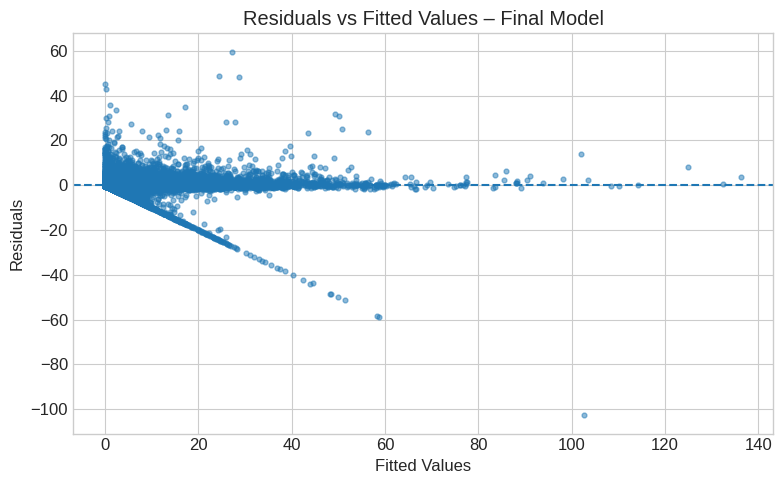

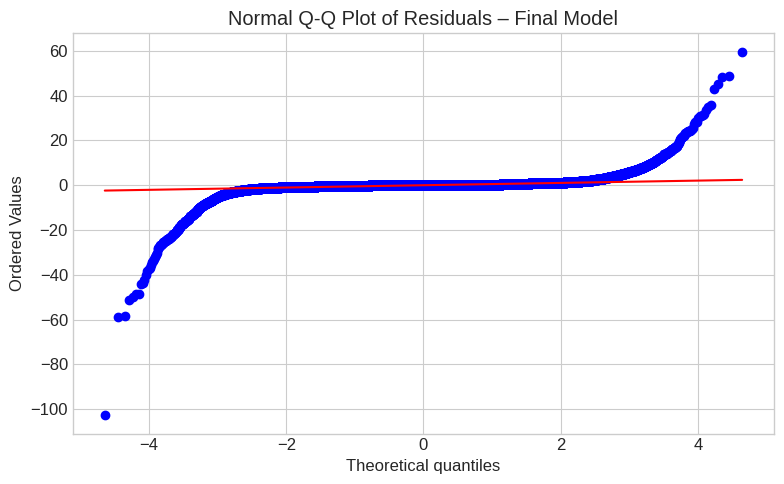

In [22]:
plt.figure(figsize=(8, 5))
plt.scatter(y_test_pred, residuals, alpha=0.5, s=12)
plt.axhline(0, linestyle='--')              # zero-residual reference
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs Fitted Values – Final Model')
plt.tight_layout()
plt.show()

# -------------  Figure 2 : Normal Q-Q plot  ---------------------
plt.figure(figsize=(8, 5))
stats.probplot(residuals, dist="norm", plot=plt)
plt.title('Normal Q-Q Plot of Residuals – Final Model')
plt.tight_layout()
plt.show()

---

## References

1. James, G., Witten, D., Hastie, T., Tibshirani, R., & Taylor, J. (2023). *An Introduction to Statistical Learning with Applications in Python* (ISLP). Springer.

2. Mayer, M. (2025). *Machine Learning Course Materials*. TH Deggendorf.

3. Scikit-learn Documentation. https://scikit-learn.org/

4. Deutsche Bahn Delays Dataset. Kaggle. https://www.kaggle.com/datasets/nokkyu/deutsche-bahn-db-delays


---

<!-- **Team Contributions:**

**Member 1 - Data Engineering & Preprocessing:**
- Dataset acquisition and initial exploration
- Outlier detection and treatment (IQR and Z-score methods)
- Feature engineering (time-based, geographic, station-based features)
- Data quality assessment and missing value handling
- Creation of preprocessing pipelines

**Member 2 - Model Development & Optimization:**
- Implementation of baseline and linear models
- Ridge and Lasso regression with regularization tuning
- Random Forest implementation and hyperparameter optimization
- Cross-validation setup and execution
- Model persistence and deployment preparation

**Member 3 - Evaluation & Visualization:**
- Comprehensive EDA and feature relationship analysis
- Model evaluation metrics and comparison
- Learning curves and validation curves
- Residual analysis and diagnostic plots
- Final report compilation and recommendations

**Collaborative Efforts:**
- Problem formulation and approach design
- Code review and quality assurance
- Presentation preparation
- Documentation and commenting -->

---